# E2f1 perturbation on pancreatic endocrine dataset

## Library imports

In [1]:
import tensorflow
import scvelo as scv
import scanpy as sc
from anndata import AnnData
from typing import Iterable, List, Literal, Optional, Sequence, Tuple, Union,Collection
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import torch
import cellrank as cr
import scipy
from scvelo.preprocessing.moments import get_moments
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap
import mplscience
import networkx as nx

import os
from regvelovi import REGVELOVI
from typing import Literal
import anndata

import torch.nn.functional as F
from paths import FIG_DIR, DATA_DIR

2024-08-05 02:02:59.078812: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 02:02:59.079312: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 02:02:59.084681: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 02:03:00.249816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 02:03:28.005616: W tensorflow/compiler/

## General settings

In [2]:
plt.rcParams['svg.fonttype'] = 'none'

sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map='viridis')

In [3]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'pancreatic_endocrine',exist_ok = True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / 'pancreatic_endocrine',exist_ok = True)

## Function defination

In [4]:
def min_max_scaling(data):
    """
    Apply min-max scaling to a numpy array or pandas Series.

    Parameters:
    data (np.ndarray or pd.Series): The input data to be scaled.

    Returns:
    np.ndarray or pd.Series: Scaled data with values between 0 and 1.
    """
    min_val = np.min(data)
    max_val = np.max(data)
    
    scaled_data = (data - min_val) / (max_val - min_val)
    
    return scaled_data

def _in_silico_block_simulation(model,adata, gene,regulation_block = True, target_block = True,effects = 0,cutoff = 1e-3):
    reg_vae_perturb = REGVELOVI.load(model,adata)
    perturb_GRN = reg_vae_perturb.module.v_encoder.fc1.weight.detach().clone()
    
    if regulation_block:
        perturb_GRN[(perturb_GRN[:,[i == gene for i in adata.var.index]].abs()>cutoff).cpu().numpy().reshape(-1),[i == gene for i in adata.var.index]] = effects
    if target_block:
        perturb_GRN[[i == gene for i in adata_target.var.index],(perturb_GRN[[i == gene for i in adata_target.var.index],:].abs()>1e-3).cpu().numpy().reshape(-1)] = effects
    
    reg_vae_perturb.module.v_encoder.fc1.weight.data = perturb_GRN
    adata_target_perturb = add_regvelo_outputs_to_adata(adata, reg_vae_perturb)
    
    return adata_target_perturb,reg_vae_perturb

def add_regvelo_outputs_to_adata(adata_raw, vae, filter = False):
    latent_time = vae.get_latent_time(n_samples=30, time_statistic = "mean",batch_size = adata_raw.shape[0])
    velocities = vae.get_velocity(n_samples=30, velo_statistic="mean",batch_size = adata_raw.shape[0])

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_regvelo"] = latent_time
    
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

In [5]:
## calculate cosine similarity
def normalize(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    return vector / norm

def cosine_similarity(vec1, vec2):
    vec1_normalized = normalize(vec1)
    vec2_normalized = normalize(vec2)
    return np.dot(vec1_normalized, vec2_normalized)
    
def cosine_dist(X_mean, Y_mean):
    # Compute KL divergence for each sample
    kl_div = []
    for i in range(X_mean.shape[1]):
        mu_x = X_mean[:, i]
        mu_y = Y_mean[:, i]

        kl = 1 - cosine_similarity(mu_x,mu_y)
        kl_div.append(kl)

    return np.array(kl_div)

def normalize_rows(array):
    # Calculate the L2 norm for each row
    norms = np.linalg.norm(array, axis=1, keepdims=True)
    # Avoid division by zero
    norms[norms == 0] = 1
    # Normalize each row by its L2 norm
    normalized_array = array / norms
    return normalized_array
    
def kl_divergence(X_mean, X_var, Y_mean, Y_var):
    # Compute KL divergence for each sample
    kl_div = []
    for i in range(X_mean.shape[1]):
        mu_x = X_mean[:, i]
        sigma_x = X_var[:, i]
        mu_y = Y_mean[:, i]
        sigma_y = Y_var[:, i]

        kl = np.mean(np.log(sigma_y+1e-6) - np.log(sigma_x+1e-6) + (1e-6 + sigma_x**2 + (mu_x - mu_y)**2) / (1e-6 + 2 * sigma_y**2) - 0.5)
        kl_div.append(kl)

    return np.array(kl_div)

In [6]:
def GRN_Jacobian(reg_vae,Ms):
    net = reg_vae.module.v_encoder.fc1.weight.detach()
    bias = reg_vae.module.v_encoder.fc1.bias.detach() 
    max_rate = reg_vae.module.v_encoder.alpha_unconstr_max.detach()
    ## calculate the jacobian matrix respect to each cell
    Jaco_m = []
    for i in range(Ms.shape[0]):
        s = Ms[i,:]
        ## calculate sigmoid probability
        #alpha_unconstr = torch.matmul(net,torch.tensor(s[reg_vae.module.v_encoder.regulator_index]))
        #alpha_unconstr = alpha_unconstr + bias
        #alpha_unconstr = reg_vae.module.v_encoder.fc1(torch.tensor(s[reg_vae.module.v_encoder.regulator_index]).to("cuda:0")).detach()
        #coef = (F.sigmoid(alpha_unconstr))
        #alpha_max = torch.clamp(F.softplus(max_rate),0,50)
        #Jaco_m.append(torch.matmul(torch.diag(coef), net))
        Jaco_m.append(reg_vae.module.v_encoder.GRN_Jacobian(torch.tensor(s[reg_vae.module.v_encoder.regulator_index]).to("cuda:0")).detach())
    Jaco_m = torch.stack(Jaco_m,2)
    return Jaco_m

In [7]:
def calculate_aurocs(targets, thresholds):
    auroc_scores_1 = []
    auroc_scores_2 = []

    for threshold in thresholds:
        # Convert continuous ground truth to binary based on threshold
        chip_targets = np.array(chip_target.index.tolist())[chip_target.iloc[:,0]>threshold].tolist()
        targets.loc[:,"gt"] = 0
        targets.loc[:,"gt"][targets.index.isin(chip_targets)] = 1
        
        # Calculate AUROC scores
        #auroc_1 = roc_auc_score(targets.loc[:,"gt"], targets.loc[:,"prior"])
        #auroc_2 = roc_auc_score(targets.loc[:,"gt"], targets.loc[:,"weight"])  # Example of second AUROC (could be another model)
        fpr, tpr, thresholds = metrics.roc_curve(targets.loc[:,"gt"], targets.loc[:,"prior"])
        auroc_1 = metrics.auc(fpr, tpr)
        fpr, tpr, thresholds = metrics.roc_curve(targets.loc[:,"gt"], targets.loc[:,"weight"])
        auroc_2 = metrics.auc(fpr, tpr)

        auroc_scores_1.append(auroc_1)
        auroc_scores_2.append(auroc_2)
    
    return auroc_scores_1, auroc_scores_2

## Data loading

In [8]:
model_path = DATA_DIR / "pancreatic_endocrine" / "rgv_model9"
data_path = DATA_DIR / "pancreatic_endocrine" / "reg_bdata.h5ad"

In [9]:
reg_bdata = sc.read_h5ad(data_path)
TF = pd.read_csv("RegVelo_datasets/pancreatic endocrine/allTFs_mm.txt",header = None)

In [10]:
W = reg_bdata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [11]:
reg_vae = REGVELOVI.load(model_path,reg_bdata)
adata_target = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)
scv.tl.velocity_graph(adata_target)

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/rgv_model9
         /model.pt already downloaded                                                                              
computing velocity graph (using 1/128 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


In [12]:
scv.tl.score_genes_cell_cycle(adata_target)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


In [13]:
adata_target_raw = adata_target.copy()
adata_target = adata_target[adata_target.obs["phase"] != "G1"].copy()

## correlate pearson correlation between gene expression and s score and g2m score

In [14]:
score = min_max_scaling(adata_target.obs["S_score"]) - min_max_scaling(adata_target.obs["G2M_score"])
gene_ranking = []
for i in range(adata_target.shape[1]):
    gene_ranking.append(scipy.stats.pearsonr(adata_target.X.A[:,i],score)[0])
rank_df = pd.DataFrame({"Ranking":gene_ranking})
rank_df.index = adata_target.var_names.tolist()

In [15]:
rank_df.loc[list(set(TF.iloc[:,0]).intersection(adata_target.var_names.to_list())),:].sort_values(by='Ranking',ascending=False)

,Ranking
E2f1,0.296208
Tagln2,0.098785
Rest,0.087569
Sox9,0.069165
Hhex,0.063846
...,...
Neurog3,-0.144074
Hmgb3,-0.170198
H2afz,-0.190133
Hmgb2,-0.407774


In [16]:
genes_to_plot = rank_df.loc[list(set(TF.iloc[:,0]).intersection(adata_target.var_names.to_list())),:].sort_values(by='Ranking',ascending=False)

In [17]:
## plot the heatmap and show the phase pivot genes
adata_plot = adata_target.copy()
adata_plot.obs['S_score_vs_G2M_score'] = 1 - pd.to_numeric(score)  # Ensure pseudotime is numeric
adata_plot = adata_plot[adata_plot.obs.sort_values('S_score_vs_G2M_score').index]

In [18]:
sc.pp.neighbors(adata_plot)
ck = cr.kernels.ConnectivityKernel(adata_plot).compute_transition_matrix()
g = cr.estimators.GPCCA(ck)
## evaluate the fate prob on original space
g.compute_macrostates(n_states=7,cluster_key="clusters")
g.set_terminal_states(["Beta"])
g.compute_fate_probabilities()

  0%|          | 0/1 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: 

In [19]:
## using cellrank to plot figure
model = cr.models.GAM(adata_plot)

  0%|          | 0/50 [00:00<?, ?gene/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket


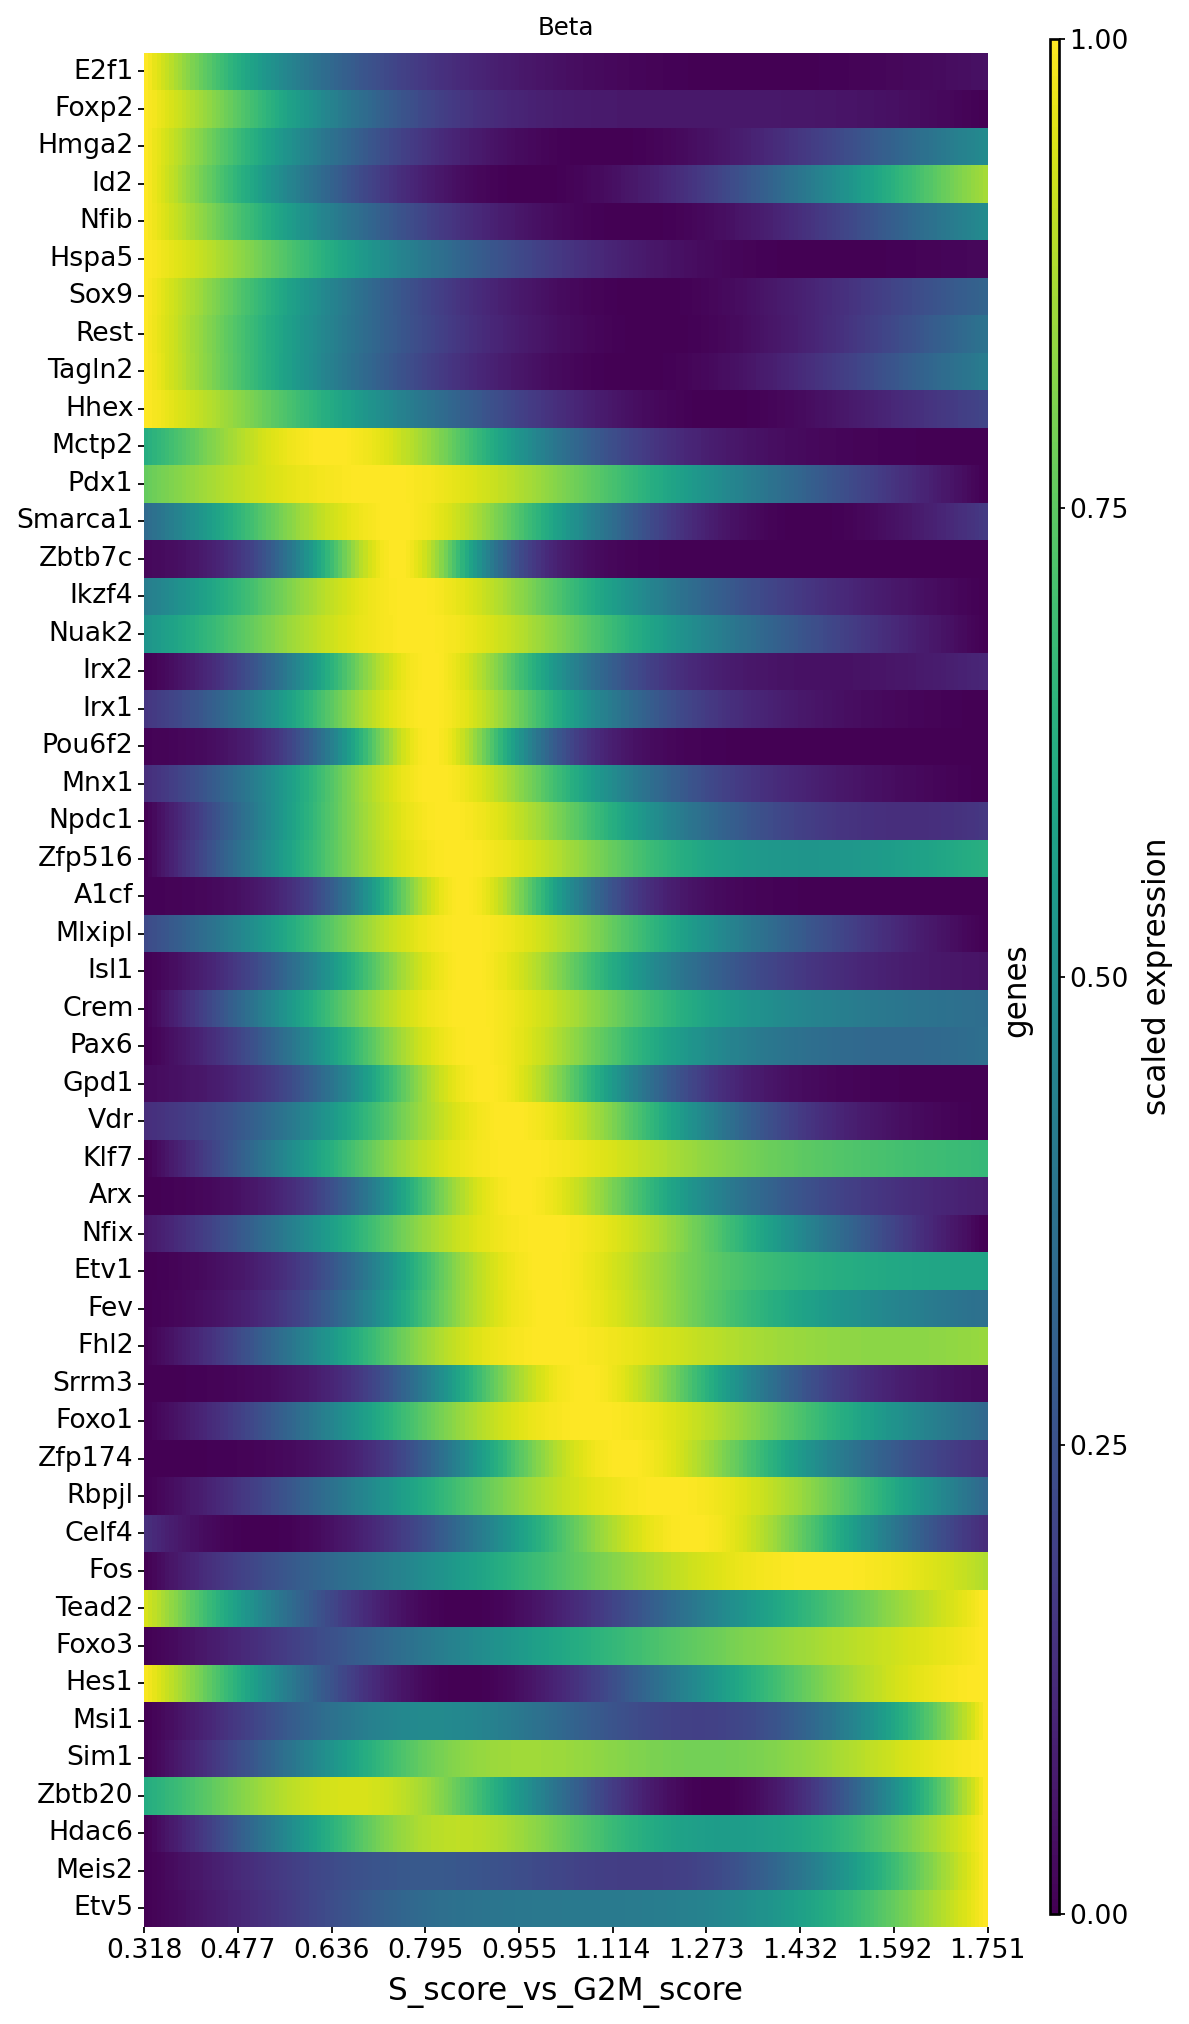

In [20]:
if SAVE_FIGURES:
    with mplscience.style_context():
        cr.pl.heatmap(
        adata_plot,
        model,
        genes=genes_to_plot[:50].index.tolist(),
        show_fate_probabilities=False,
        show_all_genes=True,
        time_key="S_score_vs_G2M_score",
        keep_gene_order = True,
        figsize=(8,15),
        save = FIG_DIR / 'pancreatic_endocrine'/ 'E2f1_perturbation' / 'heatmap_plot.svg'
    )

In [21]:
adata_target = adata_target_raw.copy()

## perform E2f1 perturbation simulation

In [22]:
adata_target_perturb,reg_vae_perturb =  _in_silico_block_simulation(model_path,reg_bdata,"E2f1",target_block = False,cutoff = 0)

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/rgv_model9
         /model.pt already downloaded                                                                              


In [23]:
vec = cosine_dist(adata_target.layers["velocity"].T, adata_target_perturb.layers["velocity"].T)
adata_target_perturb.obs["perturbation_effect"] = vec

In [24]:
exp = get_moments(adata_target, normalize_rows(adata_target.layers["velocity"]), second_order=False).astype(np.float64, copy=False)
var = get_moments(adata_target, normalize_rows(adata_target.layers["velocity"]), second_order=True).astype(np.float64, copy=False)
exp_perturb = get_moments(adata_target_perturb, normalize_rows(adata_target_perturb.layers["velocity"]), second_order=False).astype(np.float64, copy=False)
var_perturb = get_moments(adata_target_perturb, normalize_rows(adata_target_perturb.layers["velocity"]), second_order=True).astype(np.float64, copy=False)
vec = kl_divergence(exp.T, var.T, exp_perturb.T, var_perturb.T)
adata_target_perturb.obs["KL_divergence"] = np.log2(vec+1)

vec = ((exp - exp_perturb)**2).sum(1)
adata_target_perturb.obs["first moment"] = np.log2(vec+1)

vec = np.abs(np.log2(var_perturb.sum(1)+1) - np.log2(var.sum(1)+1))
#vec[~np.isnan(vec)] = min_max_scaling(vec[~np.isnan(vec)])
adata_target_perturb.obs["second moment"] = vec

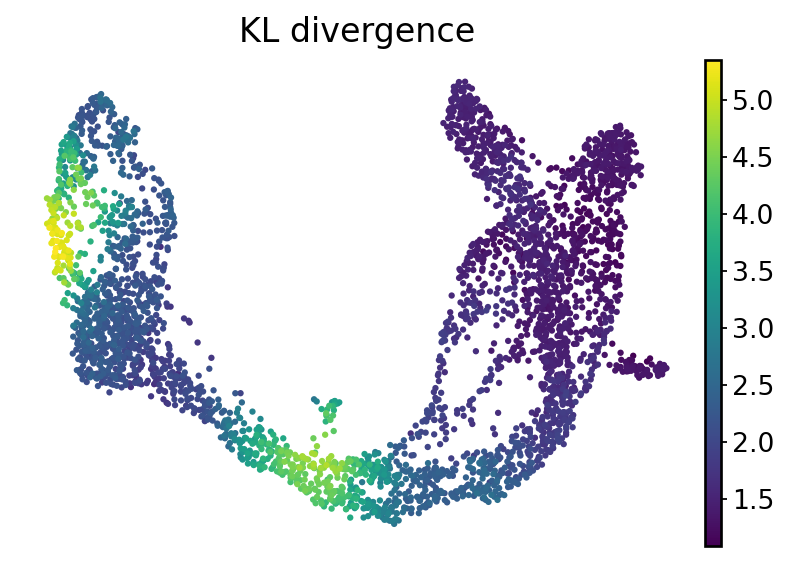

In [25]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.umap(
            adata_target_perturb,
            color="KL_divergence",
            cmap="viridis",
            title="KL divergence",
            ax=ax,
            frameon = False,
        )

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'pancreatic_endocrine'/ 'E2f1_perturbation' / 'KL_divergence.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

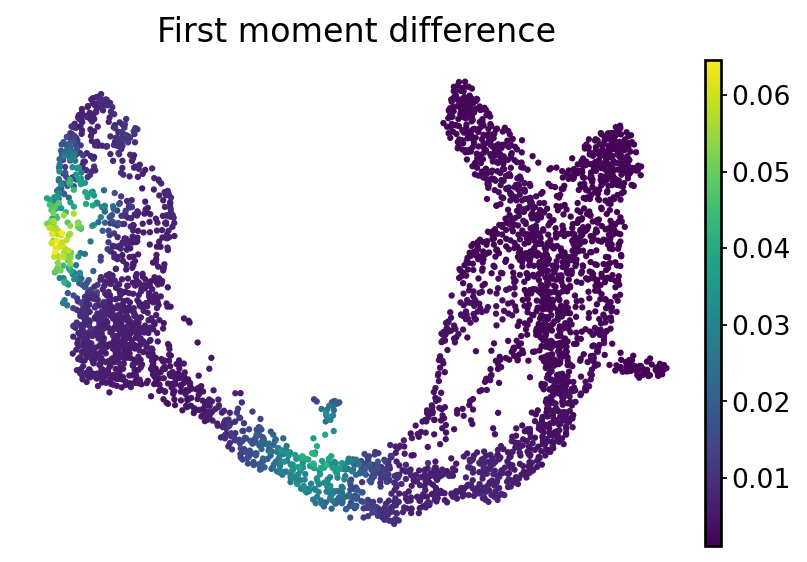

In [26]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.umap(
            adata_target_perturb,
            color="first moment",
            cmap="viridis",
            title="First moment difference",
            ax=ax,
            frameon = False,
        )

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'pancreatic_endocrine'/ 'E2f1_perturbation' / 'first_moment.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

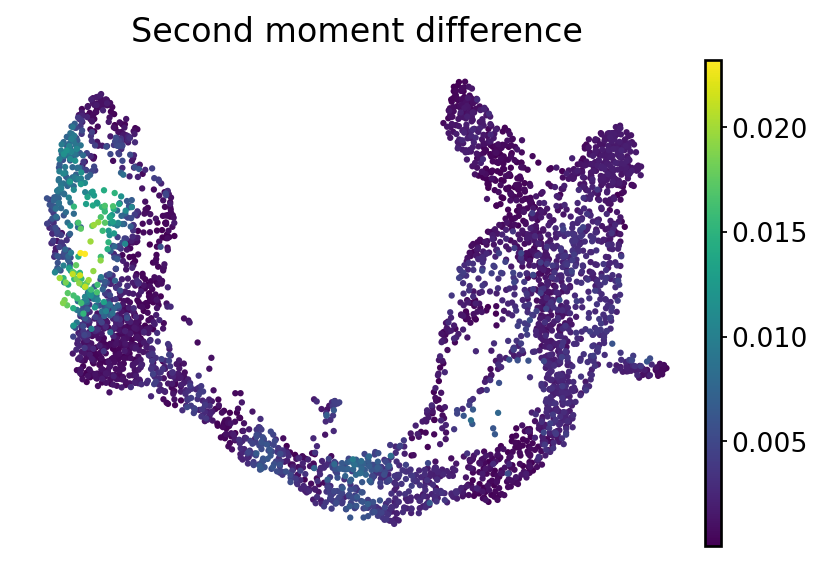

In [27]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.umap(
            adata_target_perturb,
            color="second moment",
            cmap="viridis",
            title="Second moment difference",
            ax=ax,
            frameon = False,
        )

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'pancreatic_endocrine'/ 'E2f1_perturbation' / 'second_moment.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

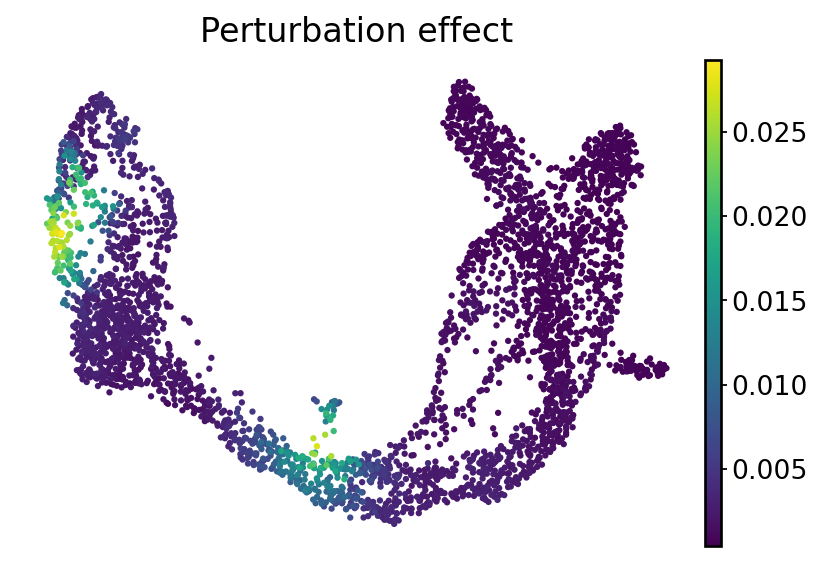

In [28]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.umap(
            adata_target_perturb,
            color="perturbation_effect",
            cmap="viridis",
            title="Perturbation effect",
            ax=ax,
            frameon = False,
        )

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'pancreatic_endocrine'/ 'E2f1_perturbation' / 'perturbation_effect.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


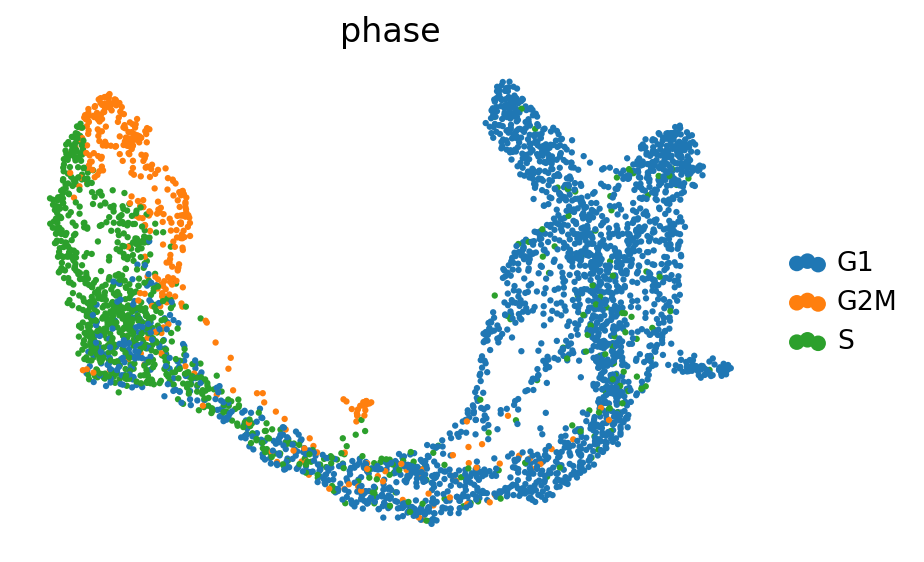

In [29]:
adata_target_perturb.obs["phase"] = adata_target.obs["phase"].copy()
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.umap(
            adata_target,
            color="phase",
            ax = ax,
            frameon = False,
        )

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'pancreatic_endocrine'/ 'E2f1_perturbation' / 'phase_label.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

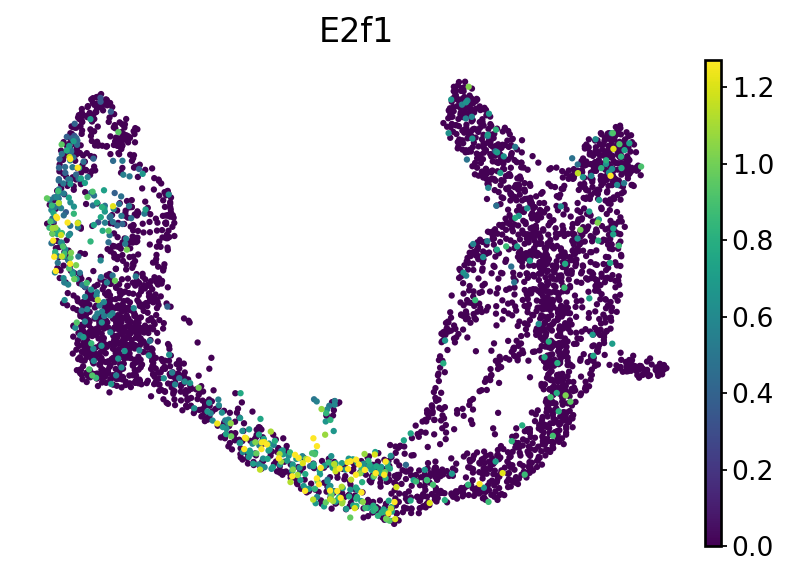

In [30]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.umap(
            adata_target, 
            color="E2f1",
            vmin="p1",
            vmax="p99",
            frameon = False,
            ax = ax
        )

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'pancreatic_endocrine'/ 'E2f1_perturbation' / 'E2f1_express.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

In [31]:
PS = adata_target_perturb.obs["perturbation_effect"][(adata_target_perturb.obs["clusters"] == "Ductal") & (adata_target.obs["phase"] == "S")].tolist() + adata_target_perturb.obs["perturbation_effect"][adata_target_perturb.obs["clusters"] == "Ngn3 high EP"].tolist() + adata_target_perturb.obs["perturbation_effect"][adata_target_perturb.obs["clusters"] == "Ngn3 low EP"].tolist()

In [32]:
import scipy
x = [2] * np.sum((adata_target_perturb.obs["clusters"] == "Ductal") & (adata_target.obs["phase"] == "S")) + [1] * np.sum(adata_target.obs["clusters"] == "Ngn3 high EP") + [0] * np.sum(adata_target_perturb.obs["clusters"] == "Ngn3 low EP")
#KL = scipy.stats.zscore(KL)
PS = np.array(PS)
difference = [np.mean(PS[np.array(x)==2]), np.mean(PS[np.array(x)==0]), np.mean(PS[np.array(x)==1])]
difference1 = difference / np.sqrt(np.var(difference))
#scipy.stats.pearsonr(np.array(x),np.array(KL))
difference1

array([4.57449406, 2.30097344, 4.22724499])

In [33]:
GEP = adata_target_perturb[(adata_target_perturb.obs["clusters"] == "Ductal") & (adata_target.obs["phase"] == "S"),"E2f1"].X.A.reshape(-1).tolist() + adata_target_perturb[adata_target_perturb.obs["clusters"] == "Ngn3 high EP","E2f1"].X.A.reshape(-1).tolist() + adata_target_perturb[adata_target_perturb.obs["clusters"] == "Ngn3 low EP","E2f1"].X.A.reshape(-1).tolist()

In [34]:
import scipy
x = [2] * np.sum((adata_target_perturb.obs["clusters"] == "Ductal") & (adata_target.obs["phase"] == "S")) + [1] * np.sum(adata_target_perturb.obs["clusters"] == "Ngn3 high EP") + [0] * np.sum(adata_target_perturb.obs["clusters"] == "Ngn3 low EP")
#KL = scipy.stats.zscore(KL)
GEP = np.array(GEP)
difference = [np.mean(GEP[np.array(x)==2]), np.mean(GEP[np.array(x)==0]),np.mean(GEP[np.array(x)==1])]
difference2 = difference / np.sqrt(np.var(difference))
#scipy.stats.pearsonr(np.array(x),np.array(KL))
difference2

array([2.00257551, 0.9413374 , 3.38384825])

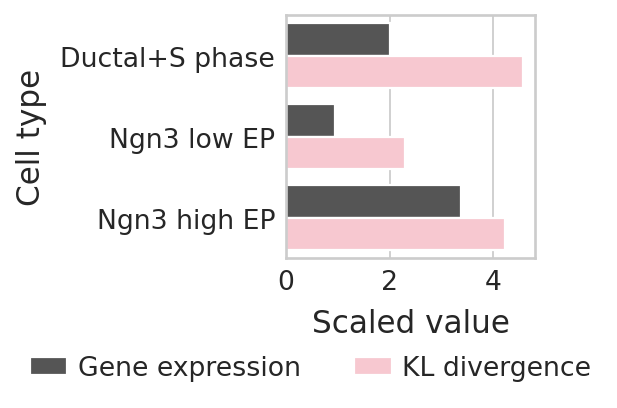

In [35]:
## Visualize the effects through the barplot
sns.set_style("ticks")
figsize=(2, 2)
df = pd.DataFrame(difference2.tolist() + difference1.tolist())
df.columns = ["Scaled value"]
df["Cell type"] = ["Ductal+S phase","Ngn3 low EP","Ngn3 high EP"] * 2
df["Group"] = ["Gene expression"]*3 + ["KL divergence"]*3
palette = {"Gene expression":"#555555","KL divergence":"#ffc0cb"}
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(
        data=df,
        x="Scaled value",
        y="Cell type",
        hue = "Group",
        ax=ax,
        palette=palette,
    )
    #ax.set(ylim=(-2.1,2.1))
    plt.legend(loc='upper center', bbox_to_anchor=(0.1,-0.3), ncol=2)
    plt.show()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'pancreatic_endocrine'/ 'E2f1_perturbation' / 'perturb_express_compare_e2f1.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

In [36]:
## repeat models
for nrun in range(0,5):
    print("training model...")
    REGVELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
    reg_vae = REGVELOVI(reg_bdata,W=W.T,regulators = TF.iloc[:,0].tolist())
    #reg_vae.module.v_encoder.grn.data = reg_vae.module.v_encoder.grn.data * W.T
    reg_vae.train()
    
    print("save model...")
    model_name = "rgv_model_" + str(nrun)
    model = DATA_DIR / "pancreatic_endocrine" / "cell_cycle_repeat_runs" / model_name
    reg_vae.save(model)

training model...


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80GB P

Epoch 1467/1500:  98%|█████████▊| 1467/1500 [18:52<00:25,  1.30it/s, loss=-2.33e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2634.522. Signaling Trainer to stop.
save model...
training model...


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80GB P

Epoch 1345/1500:  90%|████████▉ | 1345/1500 [17:12<01:58,  1.30it/s, loss=-2.29e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2605.917. Signaling Trainer to stop.
save model...
training model...


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80GB P

Epoch 1500/1500: 100%|██████████| 1500/1500 [19:12<00:00,  1.30it/s, loss=-2.31e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [19:12<00:00,  1.30it/s, loss=-2.31e+03, v_num=1]
save model...
training model...


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80GB P

Epoch 1500/1500: 100%|██████████| 1500/1500 [19:10<00:00,  1.30it/s, loss=-2.36e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [19:10<00:00,  1.30it/s, loss=-2.36e+03, v_num=1]
save model...
training model...


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80GB P

Epoch 1500/1500: 100%|██████████| 1500/1500 [19:11<00:00,  1.30it/s, loss=-2.36e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [19:11<00:00,  1.30it/s, loss=-2.36e+03, v_num=1]
save model...


In [37]:
reg_bdata.obs["phase"] = adata_target.obs["phase"].copy()

In [38]:
## aggregate GRN
model = DATA_DIR / "pancreatic_endocrine" / "cell_cycle_repeat_runs" / "rgv_model_0"
### load model
reg_vae = REGVELOVI.load(model,reg_bdata)
#grn1 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
grn1 = reg_vae.module.v_encoder.GRN_Jacobian(torch.tensor(reg_bdata.layers["Ms"][(reg_bdata.obs["clusters"] == "Ductal") & (reg_bdata.obs["phase"] == "S"),:]).to("cuda:0")).cpu().detach().clone()


model = DATA_DIR / "pancreatic_endocrine" / "cell_cycle_repeat_runs" / "rgv_model_1"
### load model
reg_vae = REGVELOVI.load(model,reg_bdata)
#grn2 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
grn2 = reg_vae.module.v_encoder.GRN_Jacobian(torch.tensor(reg_bdata.layers["Ms"][(reg_bdata.obs["clusters"] == "Ductal") & (reg_bdata.obs["phase"] == "S"),:]).to("cuda:0")).cpu().detach().clone()

model = DATA_DIR / "pancreatic_endocrine" / "cell_cycle_repeat_runs" / "rgv_model_2"
### load model
reg_vae = REGVELOVI.load(model,reg_bdata)
#grn3 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
grn3 = reg_vae.module.v_encoder.GRN_Jacobian(torch.tensor(reg_bdata.layers["Ms"][(reg_bdata.obs["clusters"] == "Ductal") & (reg_bdata.obs["phase"] == "S"),:]).to("cuda:0")).cpu().detach().clone()

model = DATA_DIR / "pancreatic_endocrine" / "cell_cycle_repeat_runs" / "rgv_model_3"
### load model
reg_vae = REGVELOVI.load(model,reg_bdata)
#grn4 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
grn4 = reg_vae.module.v_encoder.GRN_Jacobian(torch.tensor(reg_bdata.layers["Ms"][(reg_bdata.obs["clusters"] == "Ductal") & (reg_bdata.obs["phase"] == "S"),:]).to("cuda:0")).cpu().detach().clone()

model = DATA_DIR / "pancreatic_endocrine" / "cell_cycle_repeat_runs" / "rgv_model_4"
### load model
reg_vae = REGVELOVI.load(model,reg_bdata)
#grn5 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
grn5 = reg_vae.module.v_encoder.GRN_Jacobian(torch.tensor(reg_bdata.layers["Ms"][(reg_bdata.obs["clusters"] == "Ductal") & (reg_bdata.obs["phase"] == "S"),:]).to("cuda:0")).cpu().detach().clone()

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/cell_cycle
         _repeat_runs/rgv_model_0/model.pt already downloaded                                                      
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/cell_cycle
         _repeat_runs/rgv_model_1/model.pt already downloaded                                                      
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/cell_cycle
         _repeat_runs/rgv_model_2/model.pt already downloaded           

In [39]:
stacked_tensors = torch.stack((grn1,grn2,grn3,grn4,grn5))

# Compute the median across corresponding entries
grn_median = torch.mean(stacked_tensors, dim=0)

In [40]:
GRN = grn_median.clone()

In [41]:
targets = GRN[:,[i == "E2f1" for i in adata_target.var.index]].detach().cpu().numpy()
prior = reg_vae.module.v_encoder.mask_m_raw[:,[i == "E2f1" for i in adata_target.var.index]].detach().cpu().numpy()

In [42]:
targets = pd.DataFrame(targets,index = adata_target.var.index)

In [43]:
targets.loc[:,"weight"] = targets.iloc[:,0].abs()
targets.loc[:,"prior"] = prior

In [44]:
### predicting E2f1 ChIP-seq dataset
chip_target = pd.read_csv("/home/icb/weixu.wang/regulatory_velo/pancreas_dataset/figures/E2f1_function/E2f1.1.tsv",index_col = 0,sep="\t")

In [45]:
chip_targets = np.array(chip_target.index.tolist())[chip_target.iloc[:,0]>200].tolist()

In [46]:
targets.loc[:,"gt"] = 0
targets.loc[:,"gt"][targets.index.isin(chip_targets)] = 1

In [47]:
## predicting using AUROC
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(targets.loc[:,"gt"], targets.loc[:,"prior"])
metrics.auc(fpr, tpr)

0.552079829577307

In [48]:
fpr, tpr, thresholds = metrics.roc_curve(targets.loc[:,"gt"], targets.loc[:,"weight"])
metrics.auc(fpr, tpr)

0.7439174795380648

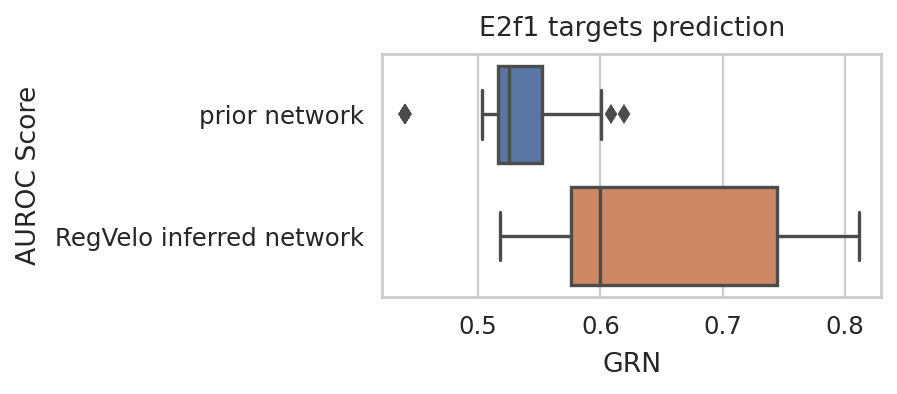

In [49]:
## select different quantile value, and look at the change of AUROC
# Function to calculate AUROC scores given a threshold
# Sample continuous ground truth and predicted scores
np.random.seed(42)  # For reproducibility

# Define thresholds using quantiles
num_thresholds = 100
quantile_99 = np.quantile(chip_target.iloc[:,0], 0.99)
thresholds = np.linspace(0, quantile_99, num_thresholds)

# Calculate AUROC scores for different thresholds
auroc_scores_1, auroc_scores_2 = calculate_aurocs(targets, thresholds)

import mplscience
plt.rcParams['svg.fonttype'] = 'none'
with mplscience.style_context():
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 2))
    data = pd.DataFrame({
        'AUROC': auroc_scores_1 + auroc_scores_2,
        'GRN': ['prior network'] * len(auroc_scores_1) + ['RegVelo inferred network'] * len(auroc_scores_2)
    })
    
    # Plot the boxplot
    sns.boxplot(y='GRN', x='AUROC', data=data)
    
    plt.xlabel('GRN')
    plt.ylabel('AUROC Score')
    plt.title('E2f1 targets prediction')

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'pancreatic_endocrine'/ 'E2f1_perturbation' / 'GRN_boxplot.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

In [50]:
scipy.stats.wilcoxon(auroc_scores_1,auroc_scores_2)

WilcoxonResult(statistic=106.0, pvalue=8.897247437325443e-17)

In [51]:
GRN_visualize = targets.sort_values('weight',ascending=False).iloc[:20,:]

In [52]:
df = pd.DataFrame({'from':["E2f1"]*20,
                   'to':GRN_visualize.index.tolist(),
                   'status':GRN_visualize.loc[:,"prior"]})

In [53]:
#df.loc[df['to'] == node, 'status'].values[0]

In [54]:
color_map = ["skyblue"]
for node in GRN_visualize.index.tolist():
    if df.loc[df['to'] == node, 'status'].values[0] == 1:
        color_map.append('darkgrey')
    else:
        color_map.append('lightgrey')

In [55]:
G = nx.from_pandas_edgelist(df,source = 'from',target='to',create_using=nx.DiGraph())

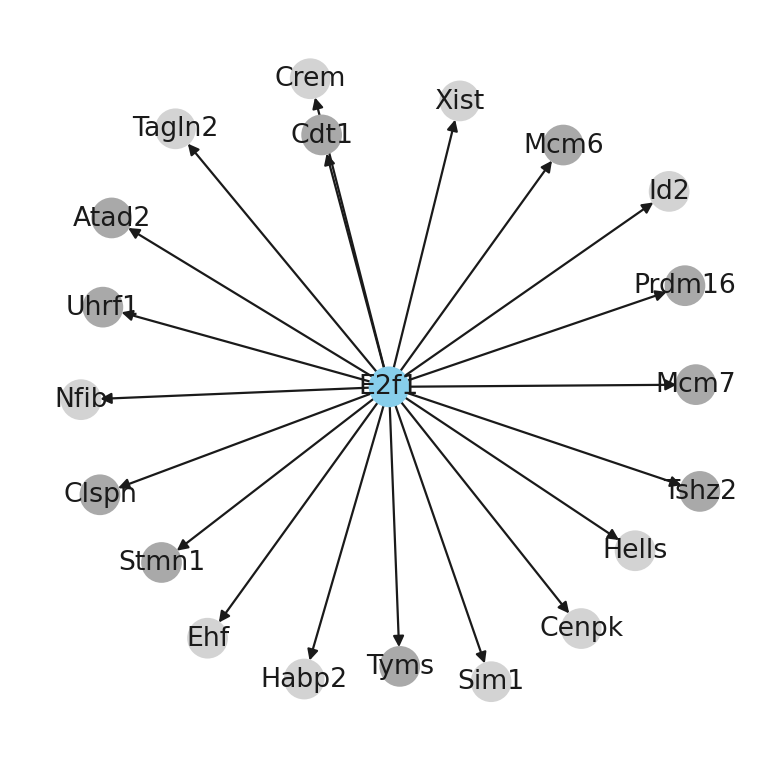

In [56]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 6))
    pos = nx.spring_layout(G)
    nx.draw(G,pos, with_labels=True, arrowsize=10,node_color=color_map)

if SAVE_FIGURES:
    fig.savefig(
            FIG_DIR / 'pancreatic_endocrine'/ 'E2f1_perturbation' / 'E2f1_GRN.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )